In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.aln import ALNModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_aln

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

# This function reads out the final state of a simulation
def getfinalstate(model):
    N = model.params.Cmat.shape[0]
    V = len(model.state_vars)
    T = model.getMaxDelay() + 1
    state = np.zeros((N, V, T))
    for v in range(V):
        if "rates" in model.state_vars[v] or "IA" in model.state_vars[v]:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n, -T:]
        else:
            for n in range(N):
                state[n, v, :] = model.state[model.state_vars[v]][n]
    return state


def setinitstate(model, state):
    N = model.params.Cmat.shape[0]
    V = len(model.init_vars)
    T = model.getMaxDelay() + 1

    for n in range(N):
        for v in range(V):
            if "rates" in model.init_vars[v] or "IA" in model.init_vars[v]:
                model.params[model.init_vars[v]] = state[:, v, -T:]
            else:
                model.params[model.init_vars[v]] = state[:, v, -1]

    return

def getstate(model):
    state = np.concatenate(  ( np.concatenate((model.params["rates_exc_init"][:, np.newaxis, -1],
                                            model.params["rates_inh_init"][:, np.newaxis, -1],
                                            model.params["IA_init"][:, np.newaxis, -1], ), axis=1, )[:, :, np.newaxis],
                            np.stack((model.rates_exc, model.rates_inh, model.IA), axis=1),),axis=2,  )
    
    return state

In [2]:
data = dict()

In [3]:
p_names = ["A", "B", "C", "D"]
coords = [[0., 0.7], [1., 1.5], [2., 0.8], [2.5, 1.8]]

for i in range(len(p_names)):
    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    data[p]["target_period"] = 15.
    if i == 0: data[p]["w1"] = np.array([0.00005, 0.0005, 0.005, 0.05, 0.5])
    elif i == 1: data[p]["w1"] = np.array([0.00005, 0.0005, 0.005, 0.05, 0.5])
    elif i == 2: data[p]["w1"] = np.array([0.00005, 0.05, 0.2])# np.arange(0.01, 0.21, 0.05) # 0.195 gives zero/ 0.05 does not produce giggling control
    elif i == 3: data[p]["w1"] = np.array([0.00005, 0.05, 0.13]) #np.array([0.001, 0.131, 0.05]) # 0.124
    data[p]["control"] = [None for x in range(len(data[p]["w1"]))]
    data[p]["state"] = [None for x in range(len(data[p]["w1"]))]

N = 1
model = ALNModel()
dt = model.params.dt

if False:
    for i in range(len(p_names)):
        p = data[p_names[i]]["coordinates"]
        model.params.mue_ext_mean = p[0]
        model.params.mui_ext_mean = p[1]

        model.params.duration = 1000.
        input = ZeroInput().generate_input(duration=model.params.duration+dt, dt=model.params.dt)
        input[0,:1000] = 5.
        input[0,5000:6000] = -5.
        model.params["ext_exc_current"] = input
        model.run()

        plt.plot(model.t, model.rates_exc[0,:])
        plt.show()

In [153]:
for i in range(len(p_names)):

    if i in [2,3]:
        continue

    p = p_names[i]
    if i == 0: data[p]["w1"] = np.array([0.00005, 0.0005, 0.005, 0.05, 0.5, 5.])
    elif i == 1: data[p]["w1"] = np.array([0.00005, 0.0005, 0.005, 0.05, 0.5, 5.])
    data[p]["control"].append(None)
    data[p]["state"].append(None)

In [4]:
controlmat = np.zeros((N,3))
controlmat[:,0] = 1.

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

it = 200
maxstr = 5

pr = np.arange(0,101,1)
dir = "images_1n_aln_w1"

In [17]:
for i in range(len(p_names)):
    
    p = data[p_names[i]]["coordinates"]
    print("pind = ", i, p_names[i], p)
    
    testd = 10000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    model.params["ext_exc_current"] = test_input
    model.params.mue_ext_mean = p[0]
    model.params["ext_inh_current"] = test_input
    model.params.mui_ext_mean = p[1]
    model.run()

    setinitstate(model, getfinalstate(model))

    if i in [0,1]: duration = 200.
    else: duration = 120.

    model.params.duration = duration
    zero_input0 = ZeroInput().generate_input(duration=duration+dt, dt=model.params.dt)
    zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
    zero_control = np.vstack( ([zero_input]*N))

    model.params["ext_exc_current"] = zero_control[:,0,:]
    model.params["ext_inh_current"] = zero_control[:,0,:]
    model.run()

    #plt.plot(model.t, model.rates_exc[0,:])
    #plt.show()
    #continue

    target_period = data[p_names[i]]["target_period"]
    i00 = 0
    int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
    while int0 > 2*target_period/dt:
        i00 += 1
        int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)

    for iw in range(len(data[p_names[i]]["w1"])):

        w1 = data[p_names[i]]["w1"][iw]
        print("iw = ", iw, w1)

        model_controlled = oc_aln.OcAln(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.step = 1e-2
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_1D"] = w1
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data[p_names[i]]["control"][iw]) != type(None):
                model_controlled.control = data[p_names[i]]["control"][iw].copy()
                model_controlled.update_input()

        if False:
            model_controlled.control[0,0,:] = 1. +  np.sin(2. * np.pi * np.arange(0, duration+dt, dt)/target_period)
            model_controlled.update_input()

        model_controlled.optimize(it)

        model_controlled.step = 1e-2
        model_controlled.optimize(it)

        data[p_names[i]]["control"][iw] = model_controlled.control.copy()
        data[p_names[i]]["state"][iw] = model_controlled.get_xs()

    with open('osc_1n_aln_w1.pickle', 'wb') as f:
        pickle.dump(data, f)

pind =  0 A [0.3, 0.4]
iw =  0 5e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -37.539272222714146
Converged in iteration 1 with cost -37.539272222714146
Final cost : -37.539272222714146
Compute control for a deterministic system
Cost in iteration 0: -37.539272222714146
Converged in iteration 1 with cost -37.539272222714146
Final cost : -37.539272222714146
iw =  1 0.0005
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -32.11535923575892
Converged in iteration 1 with cost -32.11535923575892
Final cost : -32.11535923575892
Compute control for a deterministic system
Cost in iteration 0: -32.11535923575892
Converged in iteration 1 with cost -32.11535923575892
Final cost : -32.11535923575892
iw =  2 0.005
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -36.45581838996093
Cost in iteration 1: -39.415

images_1n_aln_w1/A.png


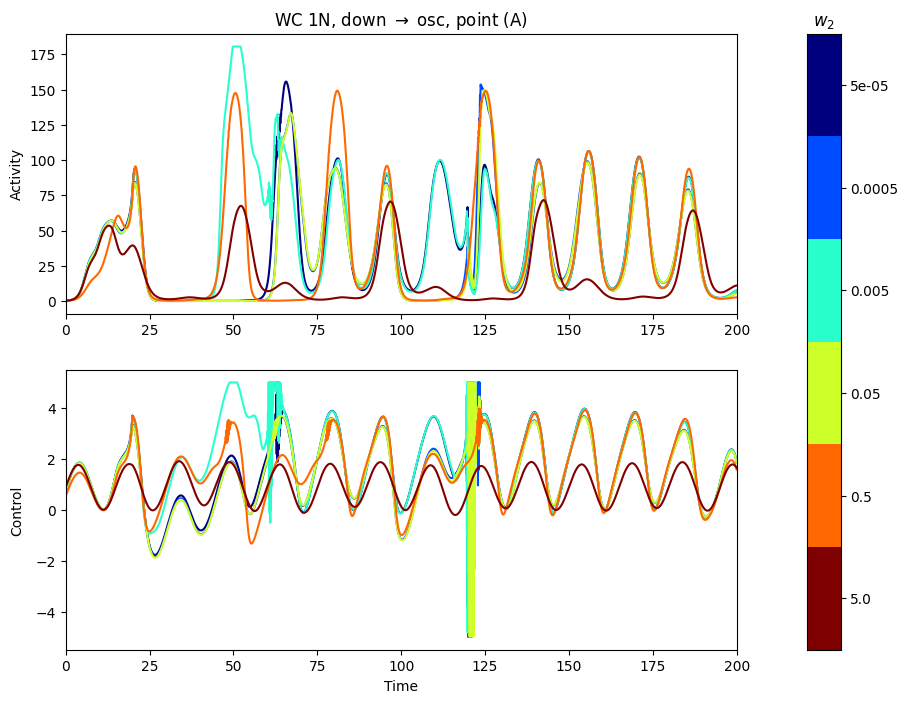

images_1n_aln_w1/B.png


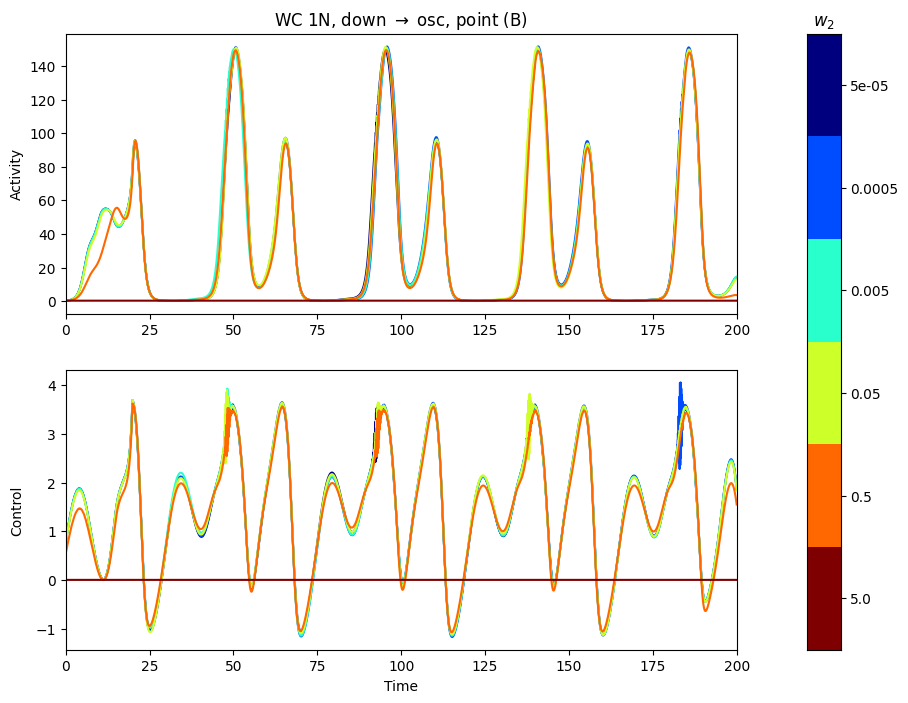

images_1n_aln_w1/C.png


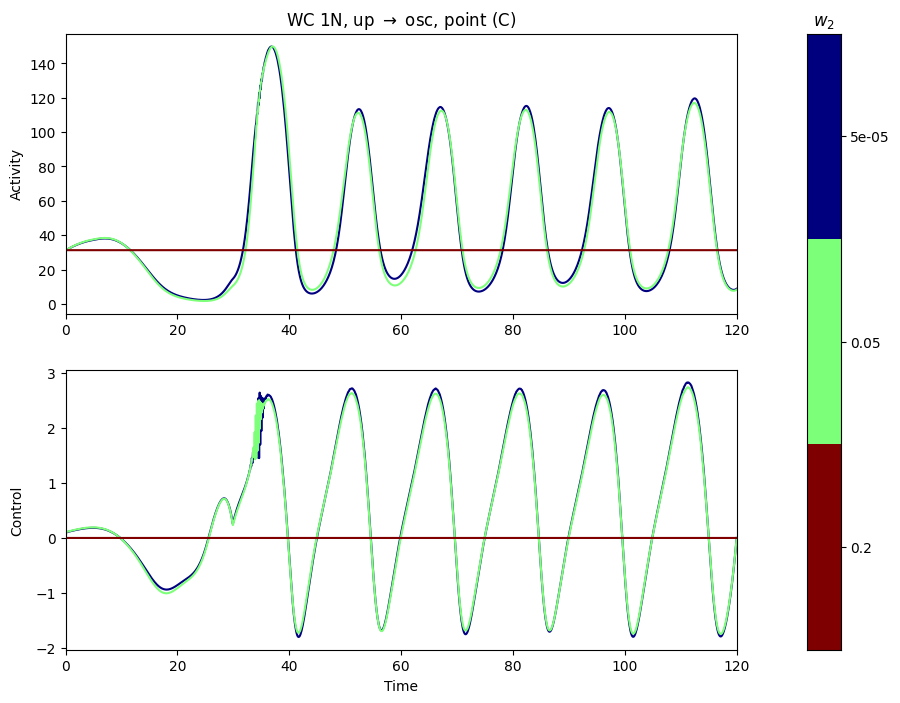

images_1n_aln_w1/D.png


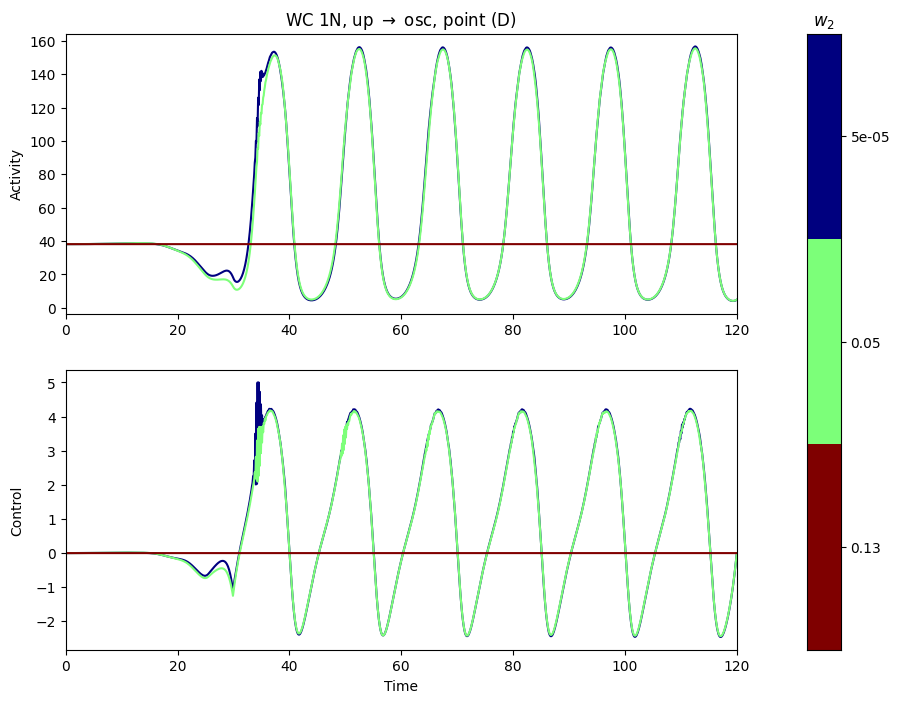

In [18]:
for i in range(len(p_names)):

    if i in [0,1]: duration = 200.
    else: duration = 120.

    filename = os.path.join(dir, p_names[i] + ".png")
    print(filename)
    plot_w(data[p_names[i]], duration, dt, filename)

In [10]:
cmap = plt.cm.get_cmap("jet")

def plot_w(data, dur, dt, filename):
    fig, ax = plt.subplot_mosaic(   [['upper left', 'right'], ['lower left', 'right']],
                                    gridspec_kw={'width_ratios': [20,1]},
                                    figsize=(10,8))
    time_array = np.arange(0, dur+dt, dt)

    for iw in range(len(data["w1"])):
        c = cmap(iw/(len(data["w1"])-1))

        ax["upper left"].plot(time_array, data["state"][iw][0,0,:], color=c)
        ax["lower left"].plot(time_array, data["control"][iw][0,0,:], color=c)

    ax["upper left"].set_xlim(0, duration)
    ax["lower left"].set_xlim(0, duration)

    ax["lower left"].set_xlabel("Time")
    ax["upper left"].set_ylabel("Activity")
    ax["lower left"].set_ylabel("Control")

    grad = np.linspace(data["w1"][0], data["w1"][-1], len(data["w1"]))
    ax["right"].imshow(np.vstack((grad, grad)).T, aspect='auto', cmap=cmap)
    ax["right"].set_xticks([])
    ax["right"].set_yticks(np.arange(0,len(data["w1"]),1))
    ax["right"].set_yticklabels(np.around(data["w1"],5))
    ax["right"].yaxis.tick_right()
    ax["right"].set_title(r"$w_2$")

    title = "WC 1N, "
    if "A" in filename or "B" in filename:
        title = title + r"down $\rightarrow$ osc, point $($"
    elif "C" in filename or "D" in filename:
        title = title + r"up $\rightarrow$ osc, point $($"

    title = title + filename[-5] + r")"

    ax["upper left"].set_title(title)
    fig.align_ylabels([ax["upper left"], ax["lower left"]])
    plt.savefig(filename)
    plt.show()
    return

def plot_w_zoom(data, dur, dt, filename):
    fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'width_ratios': [3, 2]}, sharex="col", sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    for iw in range(len(data["w1"])):
        c = cmap(iw/(len(data["w1"])-1))

        ax[0, 0].plot(time_array, data["state"][iw][0,0,:], color=c, label=r"$w_2=$"+str(data["w1"][iw]))
        ax[1, 0].plot(time_array, data["control"][iw][0,0,:], color=c)

        mins = scipy.signal.find_peaks(-data["state"][iw][0,0,:])[0]
        i0, i1 = mins[-3]-10, mins[-2]+10

        time_osc = np.linspace(0, (i1-i0)*dt, i1-i0, endpoint=True)
        #print(i1 - i0)

        ax[0, 1].plot(time_osc, data["state"][iw][0,0,i0:i1], color=c)
        ax[1, 1].plot(time_osc, data["control"][iw][0,0,i0:i1], color=c)

    ax[0,0].set_xlim(0, duration)
    ax[1,0].set_xlim(0, duration)
    ax[0,1].set_xlim(0, (i1-i0)*dt)
    ax[1,1].set_xlim(0, (i1-i0)*dt)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].legend(loc="upper left")

    fig.suptitle("Point " + filename[-5])

    plt.savefig(filename)

    plt.show()
    return

In [14]:
with open('osc_1n_aln_w1.pickle', 'wb') as f:
    pickle.dump(data, f)

In [5]:
with open('osc_1n_aln_w1.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['C', 'D', 'A', 'B'])
